In [1]:
from glob import glob
from pickle import load
from scipy.stats import norm
import matplotlib.pyplot as plt
from simtk import unit
import numpy as np
from tqdm import tqdm
%matplotlib inline

pkls = glob('../data/water_cluster_rigid_near_eq/*.pkl')
#pkls = glob('../data/alanine_constrained_near_eq/*.pkl')

name = "water_cluster_rigid"
#name = "alanine_constrained"

len(pkls)

136

In [2]:
summary = []
for fname in pkls:
    with open(fname, 'rb') as f:
        summary.append(load(f))

In [3]:
summary[0]

(('ORVRO',
  Quantity(value=3.5, unit=femtosecond),
  'configuration',
  'water_cluster_rigid'),
 {'W_shads_F': array([-0.22119105, -0.08760162,  0.14476799, ...,  0.07930006,
         -0.01349103,  0.19887754]),
  'W_shads_R': array([-0.07333487,  0.27718899,  0.28993457, ..., -0.323625  ,
         -0.24121433, -0.08764643])})

In [4]:
def get_max_conf_dt_result(scheme='VRORV'):
    max_dt = 0
    for result_ in summary:
        dt = result_[0][1].value_in_unit(unit.femtosecond)
        if (dt > max_dt) and (result_[0][0] == scheme) and (result_[0][2] == 'configuration'):
            result = result_
            max_dt = dt
    print(max_dt)
    return result

In [5]:
result = get_max_conf_dt_result()

8.0


In [6]:
result

(('VRORV',
  Quantity(value=8.0, unit=femtosecond),
  'configuration',
  'water_cluster_rigid'),
 {'W_shads_F': array([ 3.74533814, -1.41116843,  4.65266214, ...,  0.01226458,
          4.18048282,  0.44953813]),
  'W_shads_R': array([ 5.07484407,  3.85312726,  4.15420854, ...,  5.9545751 ,
          0.50764597,  2.28156635])})

In [7]:
W_F = result[1]['W_shads_F']
W_R = result[1]['W_shads_R']

In [8]:
from benchmark.evaluation import estimate_nonequilibrium_free_energy

mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
mean, np.sqrt(sq_unc)

/Users/joshuafass/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


(0.038225087890616072, 0.0057997633098644157)

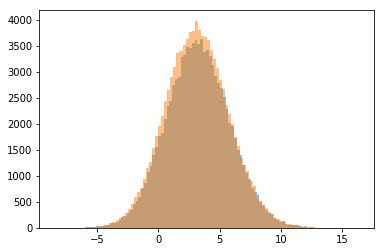

In [9]:
plt.hist(W_F, bins=100, alpha=0.5);
plt.hist(W_R, bins=100, alpha=0.5);

In [10]:
mean, np.sqrt(sq_unc)

(0.038225087890616072, 0.0057997633098644157)

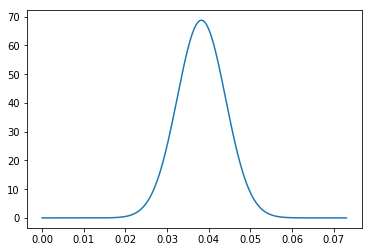

In [11]:
from scipy.stats import norm
stdev = np.sqrt(sq_unc)
n = norm(loc=mean, scale=stdev)

x_grid = np.linspace(min(0, mean - stdev * 6), mean + stdev * 6, 1000)
y_grid = np.exp(n.logpdf(x_grid))
plt.plot(x_grid, y_grid)

In [12]:
import seaborn.apionly as sns
schemes = sorted(['RVOVR', 'VRORV', 'OVRVO', 'ORVRO'])
color_schemes = dict(zip(schemes, ['Blues', 'Greens', 'Oranges', 'Purples']))

colormaps = dict()
dts = sorted(list(set([r[0][1].value_in_unit(unit.femtosecond) for r in summary])))

for scheme in schemes:
    colormap = sns.color_palette(color_schemes[scheme], n_colors=len(dts))
    colormaps[scheme] = dict(zip(dts, colormap))

dt_ = dts[int(len(dts)/2)]
colors = dict()
for scheme in schemes:
    colors[scheme] = colormaps[scheme][dt_]

In [13]:
def plot(mean, sq_unc, scheme='VRORV'):
    stdev = np.sqrt(sq_unc)
    n = norm(loc=mean, scale=stdev)

    x_grid = np.linspace(min(0, mean - stdev * 6), mean + stdev * 6, 1000)
    y_grid = np.exp(n.logpdf(x_grid))
    
    plt.plot(x_grid, y_grid, color=colors[scheme], label=scheme)

In [14]:
def nan_safe(x, y):
    """Return x, y only on indices where x[i], y[i] are both finite"""
    
    mask = np.isfinite(x) * np.isfinite(y)
    return x[mask], y[mask]

8.0
8.0
8.0
8.0


(0, 1.4347239928632465)

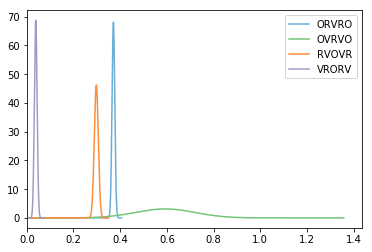

In [15]:
for scheme in schemes:
    result = get_max_conf_dt_result(scheme)
    W_F = result[1]['W_shads_F']
    W_R = result[1]['W_shads_R']
    
    W_F, W_R = nan_safe(W_F, W_R)
    
    mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
    plot(mean, sq_unc, scheme)
plt.legend(loc='best')
plt.xlim(0,)

In [17]:
def resample(x):
    return x[np.random.randint(0,len(x),len(x))]

def estimate_delta_F_using_medians(W_F, W_R):
    return 0.5 * (np.median(W_F) - np.median(W_R))

def bootstrap_median_estimates(W_F, W_R, n_bootstrap=1000):
    return np.array([estimate_delta_F_using_medians(resample(W_F), resample(W_R)) for _ in tqdm(range(n_bootstrap))])

  2%|▏         | 18/1000 [00:00<00:05, 177.49it/s]

8.0


  0%|          | 0/1000 [00:00<?, ?it/s]

8.0
8.0


  2%|▏         | 18/1000 [00:00<00:05, 176.24it/s]

8.0


100%|██████████| 1000/1000 [00:05<00:00, 180.72it/s]


(0, 1.9107744595112612)

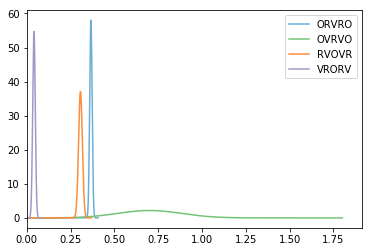

In [18]:
for scheme in schemes:
    result = get_max_conf_dt_result(scheme)
    W_F = result[1]['W_shads_F']
    W_R = result[1]['W_shads_R']
    
    W_F, W_R = nan_safe(W_F, W_R)
    
    median_estimates = bootstrap_median_estimates(W_F, W_R)
    mean, sq_unc = np.mean(median_estimates), np.std(median_estimates)**2
    #mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
    plot(mean, sq_unc, scheme)
plt.legend(loc='best')
plt.xlim(0,)

100%|██████████| 1000/1000 [00:05<00:00, 178.48it/s]


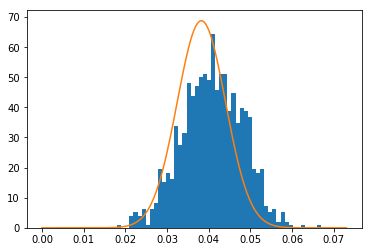

In [19]:
median_estimates = bootstrap_median_estimates(W_F, W_R)
plt.hist(median_estimates, normed=True, bins=50);
plt.plot(x_grid, y_grid)

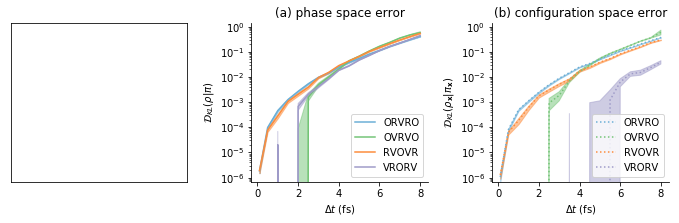

In [22]:
def get_curves_with_unc(scheme='RVOVR', marginal='configuration'):
    dts = []
    
    near_eq_estimates = []
    near_eq_unc = []
    
    for i, (descr, (result_dict)) in enumerate(summary):
        if descr[0] == scheme and descr[2] == marginal:
            dts.append(descr[1].value_in_unit(unit.femtosecond))
            
            W_F, W_R = result_dict["W_shads_F"], result_dict["W_shads_R"]
            W_F, W_R = nan_safe(W_F, W_R)
            
            mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
            
            near_eq_estimates.append(mean)
            
            near_eq_unc.append(np.sqrt(sq_unc))
    
    inds = np.argsort(dts)
    sort_by_dt = lambda l : np.array(l)[inds]
    return list(map(sort_by_dt, [dts, near_eq_estimates, near_eq_unc]))

def plot_marginal(marginal='configuration', legend=True):
    plt.title(marginal)
    
    
    linestyle = {'full': 'solid',
                 'configuration': 'dotted',
                }
    
    for i, scheme in enumerate(schemes):
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal)
        
        plt.plot(dts, near_eq_estimates, label=scheme, linestyle=linestyle[marginal], color=colors[scheme])
        plt.fill_between(dts, near_eq_estimates - near_eq_unc, near_eq_estimates + near_eq_unc, alpha=0.5, color=colors[scheme])

    
    if legend:
        plt.legend(loc='upper left', title='scheme')
    
    plt.xlabel(r'$\Delta t$ (fs)')
    
    if marginal == 'configuration':
        d_kl_arguments = r'$(\rho_\mathbf{x} \| \pi_\mathbf{x})$'
    else:
        d_kl_arguments = r'$(\rho \| \pi)$'
    plt.ylabel(r'$\mathcal{D}_{KL}$' + d_kl_arguments)

       
log = True
scale_factor = 3.2
plt.figure(figsize=(3*scale_factor,1*scale_factor))
ax = plt.subplot(1,3,1)
plt.plot(np.nan * np.ones(10))
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1,3,2)
plot_marginal('full')
plt.title('(a) phase space error')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if log:
    plt.yscale('log')
    plt.legend(loc='best')

ax = plt.subplot(1,3,3, sharey=ax)
plot_marginal('configuration', legend=False)

plt.title('(b) configuration space error')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
if log:
    plt.yscale('log')
    plt.legend(loc='best')

plt.ylim(0,)

plt.tight_layout()
plt.savefig('{}{}.jpg'.format(name, '_log_scale' if log else ''), dpi=300, bbox_inches='tight')

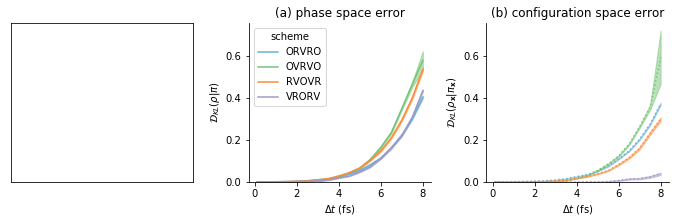

In [23]:
def get_curves_with_unc(scheme='RVOVR', marginal='configuration'):
    dts = []
    
    near_eq_estimates = []
    near_eq_unc = []
    
    for i, (descr, (result_dict)) in enumerate(summary):
        if descr[0] == scheme and descr[2] == marginal:
            dts.append(descr[1].value_in_unit(unit.femtosecond))
            
            W_F, W_R = result_dict["W_shads_F"], result_dict["W_shads_R"]
            W_F, W_R = nan_safe(W_F, W_R)
            
            mean, sq_unc = estimate_nonequilibrium_free_energy(W_F, W_R)
            
            near_eq_estimates.append(mean)
            
            near_eq_unc.append(np.sqrt(sq_unc))
    
    inds = np.argsort(dts)
    sort_by_dt = lambda l : np.array(l)[inds]
    return list(map(sort_by_dt, [dts, near_eq_estimates, near_eq_unc]))

def plot_marginal(marginal='configuration', legend=True):
    plt.title(marginal)
    
    
    linestyle = {'full': 'solid',
                 'configuration': 'dotted',
                }
    
    for i, scheme in enumerate(schemes):
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal)
        
        plt.plot(dts, near_eq_estimates, label=scheme, linestyle=linestyle[marginal], color=colors[scheme])
        plt.fill_between(dts, near_eq_estimates - near_eq_unc, near_eq_estimates + near_eq_unc, alpha=0.5, color=colors[scheme])

    
    if legend:
        plt.legend(loc='upper left', title='scheme')
    
    plt.xlabel(r'$\Delta t$ (fs)')
    
    if marginal == 'configuration':
        d_kl_arguments = r'$(\rho_\mathbf{x} \| \pi_\mathbf{x})$'
    else:
        d_kl_arguments = r'$(\rho \| \pi)$'
    plt.ylabel(r'$\mathcal{D}_{KL}$' + d_kl_arguments)

       
log = False
scale_factor = 3.2
plt.figure(figsize=(3*scale_factor,1*scale_factor))
ax = plt.subplot(1,3,1)
plt.plot(np.nan * np.ones(10))
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1,3,2)
plot_marginal('full')
plt.title('(a) phase space error')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if log:
    plt.yscale('log')
    plt.legend(loc='best')

ax = plt.subplot(1,3,3, sharey=ax)
plot_marginal('configuration', legend=False)

plt.title('(b) configuration space error')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
if log:
    plt.yscale('log')
    plt.legend(loc='best')

plt.ylim(0,)

plt.tight_layout()
plt.savefig('{}{}.jpg'.format(name, '_log_scale' if log else ''), dpi=300, bbox_inches='tight')

In [25]:
# what is the exponent?

In [26]:
ys = []
for scheme in schemes:
    _, near_eq_estimates, _ = get_curves_with_unc(scheme, "full")
    ys.append(near_eq_estimates)
[len(y) for y in ys]

[17, 17, 17, 17]

In [31]:
dts = np.array(dts)

In [42]:
def log_prob(theta):
    coeff, exponent = theta
    if min(theta) < 0:
        return -np.inf
    
    model = coeff * (dts**exponent)
    
    log_prob = 0
    for y in ys:
        log_prob -= np.sum(np.abs(y - model))
    
    return log_prob

log_prob([1e-5, 4.0])

-6.1360022478959291

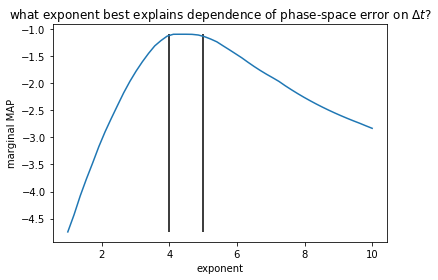

In [43]:
from scipy.optimize import fmin
exponents = np.linspace(1,10)
def marginal_map(exponent):
    f_to_min = lambda coeff: -log_prob([coeff, exponent])
    xopt = fmin(f_to_min, 1, disp=0)
    return log_prob([xopt[0], exponent])

marginal_maps = [marginal_map(exponent) for exponent in exponents]
plt.plot(exponents, marginal_maps)
#plt.yscale('log')
plt.xlabel('exponent')
plt.ylabel('marginal MAP')
plt.vlines(4,min(marginal_maps), max(marginal_maps))
plt.vlines(5,min(marginal_maps), max(marginal_maps))
plt.title('what exponent best explains dependence of phase-space error on $\Delta t$?')

In [44]:
exponents[np.argmax(marginal_maps)]

4.3061224489795915

In [45]:
import emcee
from emcee import EnsembleSampler

mcmc = EnsembleSampler(6,2,log_prob)
_ = mcmc.run_mcmc(np.random.rand(6,2), 10000)

In [46]:
max(mcmc.flatlnprobability)

-1.0986486640067832

In [47]:
mcmc.flatchain[np.argmax(mcmc.flatlnprobability)][1]

4.2897937345134336

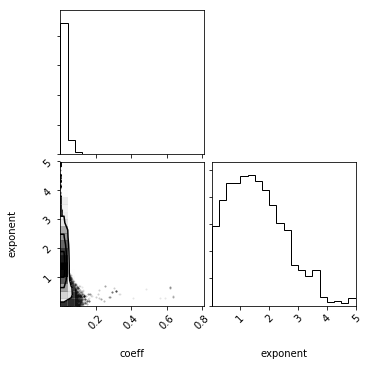

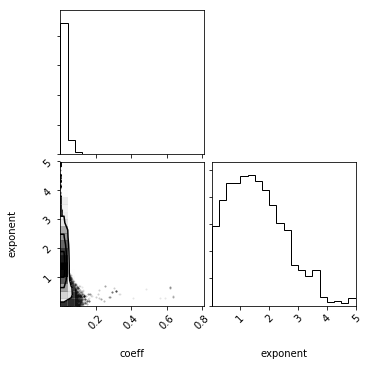

In [48]:
from corner import corner
corner(mcmc.flatchain[10000:], labels=['coeff', 'exponent'])

In [49]:
# what if we normalize by the amount of error at 2fs for ovrvo?

def plot_marginal_normalized(marginal='configuration', normalization_scheme='OVRVO', normalization_dt=2.0):
    plt.title(marginal)
    
    
    linestyle = {'full': 'solid',
                 'configuration': 'dotted',
                }
    
    
    # get error for normalization
    dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(normalization_scheme, marginal)
    normalize = near_eq_estimates[np.argmax(dts >= normalization_dt)]
    
    
    for i, scheme in enumerate(schemes):
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal)
        
        plt.plot(dts, np.abs(normalize / near_eq_estimates), label=scheme, linestyle=linestyle[marginal], color=colors[scheme])
        #plt.fill_between(dts, near_eq_estimates - near_eq_unc, near_eq_estimates + near_eq_unc, alpha=0.5, color=colors[scheme])

        plt.legend(loc='upper left', title='scheme')
    
    plt.xlabel(r'$\Delta t$ (fs)')
    
    if marginal == 'configuration':
        d_kl_arguments = r'$(\rho_\mathbf{x} \| \pi_\mathbf{x})$'
    else:
        d_kl_arguments = r'$(\rho \| \pi)$'
    plt.ylabel(r'$\mathcal{D}_{KL}$' + d_kl_arguments)

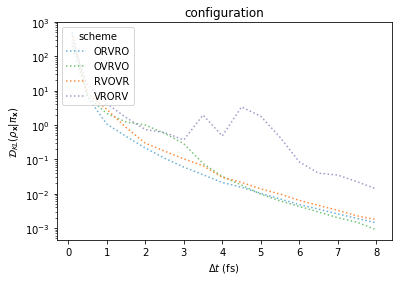

In [50]:
plot_marginal_normalized()
plt.yscale('log')

In [51]:
dts, near_eq_estimates, near_eq_unc = get_curves_with_unc("OVRVO", "configuration")
dts

array([ 0.1,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ])

In [52]:
np.argmax(dts >= 2)

4

In [53]:
# let's save the near-equilibrium estimates
result_summary = {}
for scheme in schemes:
    result_summary[scheme] = {}
    for marginal in ['configuration', 'full']:
        result_summary[scheme][marginal] = {}
        dts, near_eq_estimates, near_eq_unc = get_curves_with_unc(scheme, marginal)
        
        keys = ('dts', 'near_eq_estimates', 'near_eq_uncertainty')
        values = (dts, near_eq_estimates, near_eq_unc)
        
        for (key, value) in zip(keys, values):
            result_summary[scheme][marginal][key] = value

In [54]:
name

'water_cluster_rigid'

In [55]:
np.save('result_summary_{}.npy'.format(name), result_summary)

In [56]:
result_summary_ = np.load('result_summary_{}.npy'.format(name))

In [57]:
from pickle import dump, load

In [58]:
with open('result_summary_{}.pkl'.format(name), 'wb') as f:
    dump(result_summary, f)

In [59]:
with open('result_summary_{}.pkl'.format(name), 'rb') as f:
    result_summary_ = load(f)

In [60]:
result_summary_['OVRVO']

{'configuration': {'dts': array([ 0.1,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
          5.5,  6. ,  6.5,  7. ,  7.5,  8. ]),
  'near_eq_estimates': array([ -2.49269140e-06,  -7.83909400e-05,  -2.42206208e-04,
          -4.28247799e-04,  -5.26000632e-04,   9.16900556e-04,
           1.84178318e-03,   6.93290665e-03,   1.65265029e-02,
           2.95270107e-02,   5.39026827e-02,   8.47847588e-02,
           1.22533367e-01,   1.79270425e-01,   2.62454791e-01,
           3.54338155e-01,   5.92598824e-01]),
  'near_eq_uncertainty': array([  4.14009150e-07,   1.23290380e-05,   5.75001329e-05,
           1.44974005e-04,   2.81327297e-04,   4.74088847e-04,
           7.26410883e-04,   1.04881391e-03,   1.45065032e-03,
           1.92647132e-03,   2.51182041e-03,   3.18049304e-03,
           3.97991298e-03,   4.93631145e-03,   6.11336381e-03,
           1.12966400e-02,   1.27594722e-01])},
 'full': {'dts': array([ 0.1,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  

In [61]:
0.5 * (np.mean(W_F) - np.mean(W_R)), 0.5 * (np.median(W_F) - np.median(W_R))

(0.038225087890616072, 0.041084842865095395)